In [1]:
from astropy.table import Table
import sys
sys.path.append('analysis')
import read_mist_models
import analysis_utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as pl
from lightcurve import Lightcurve
import utils
from astropy.stats import sigma_clip
from scipy.signal import medfilt

highlight = np.array((66, 135, 245))/255

red = '#FE4365'
data = pd.read_csv('kep_tess_output/out.dat', skiprows=2, delimiter='\t')
k2dr2 = Table.read('./analysis/k2_dr2_1arcsec.fits', format='fits')
k2dr2 = k2dr2.to_pandas()
df = pd.merge(k2dr2, data, left_on='epic_number', right_on='epic')
#df = df.drop_duplicates(subset='epic_number')

#data = data.drop_duplicates(subset=['epic', 'campaign'])
data.to_hdf('kep_tess.h5', key='kep_tess', mode='w')

In [36]:
data['campaign']

0      14
1      14
2      15
3      14
4      14
       ..
244    15
245    14
246    15
247    14
248    15
Name: campaign, Length: 249, dtype: int64

In [4]:
#data[data['epic'] == 26538131]

In [15]:
import os
files = os.listdir('kep_tess_rot')
file = files[23]
lc = Lightcurve.tess('kep_tess_rot/'+file)

In [6]:
y = lc.flux - utils.trend(lc.t, lc.flux, 2)
mask = sigma_clip(y-medfilt(y, kernel_size=301), sigma=3)
x = lc.t[mask.mask == False][::5]
y = y[mask.mask == False][::5]
yerr = np.std(y - medfilt(y, kernel_size=51))

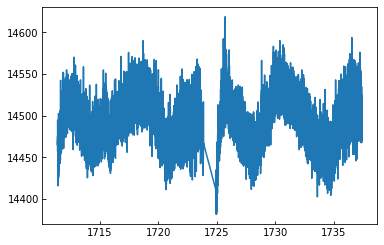

In [7]:
pl.plot(lc.t, lc.flux)

In [8]:
yerr

16.77757118813893

In [9]:
import pymc3 as pm
import exoplanet as xo
with pm.Model() as model:
    
    mean = pm.Normal("mean", mu=np.mean(y), sd=np.std(y))
    yerr = pm.Normal("yerr", mu=yerr, sd=5.0)
    logamp = pm.Normal("logamp", mu=np.log(np.var(y)), sd=5)
    period = utils.periodprior(lc.t, lc.flux)
    logQ0 = pm.Uniform("logQ0", lower=-10, upper=10)
    logdQ = pm.Normal("logdQ", mu=2.0, sd=5.0)
    mix = pm.Uniform("mix", lower=0.0, upper=1.0)
    
    logS0 = pm.Normal("logS0", mu=np.log(np.var(y)), sd=5)
    dt = lc.t[-1] - lc.t[0]
    logw = pm.Uniform("logw", lower=-20, upper=0)
    
    kernel = xo.gp.terms.RotationTerm(
        log_amp=logamp,
        period=period,
        log_Q0=logQ0,
        log_deltaQ=logdQ,
        mix=mix
    )
    kernel += xo.gp.terms.SHOTerm(
        log_S0 = logS0,
        log_w0 = logw,
        log_Q = -np.log(np.sqrt(2))
    )                  
                      
    gp = xo.gp.GP(kernel, x, yerr**2 * np.ones_like(x), mean=mean, J=6)
    gp.marginal("gp", observed = y)

    start = model.test_point
    map_soln = xo.optimize(start=start, verbose=True)
    trace = pm.sample(
        tune=10,
        draws=10,
        start=start,
        cores=2,
        chains=2,
        step=xo.get_dense_nuts_step(target_accept=0.9)
    )
    
    

/Users/tgordon/research/spindown/utils.py:44: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pks = pks[mask]
/Users/tgordon/research/spindown/utils.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  prominences = prominences[mask]
/Users/tgordon/research/spindown/utils.py:46: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different re

message: Optimization terminated successfully.
logp: -15150.781543961577 -> -15140.060920751243
Only 10 samples in chain.
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [logw, logS0, mix, logdQ, logQ0, P, logamp, yerr, mean]
Sampling 2 chains, 0 divergences: 100%|██████████| 40/40 [00:18<00:00,  1.14draws/s]
/usr/local/lib/python3.7/site-packages/pymc3/sampling.py:496: UserWarning: The number of samples is too small to check convergence reliably.
  warnings.warn("The number of samples is too small to check convergence reliably.")


/Users/tgordon/research/spindown/utils.py:44: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  pks = pks[mask]
/Users/tgordon/research/spindown/utils.py:45: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  prominences = prominences[mask]
/Users/tgordon/research/spindown/utils.py:46: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different re

array([[-1.25000000e+00,  2.87900000e+00, -6.49600000e+00,
         2.79200000e+00,  6.66000000e-01,  5.97000000e-01,
         1.90000000e+01,  1.20000000e+01,  1.80000000e+01,
         2.20000000e+01,  1.07000000e+00,  3.19105703e-01,
         1.65710000e+01,  1.67000000e-01,  1.62820000e+01,
         1.68100000e+01,  4.20000000e-02,  3.00000000e-02,
         1.60000000e+01,  1.60000000e+01,  1.60000000e+01,
         2.60000000e+01,  1.13000000e+00,  1.62820723e+01,
         6.40400000e+00,  4.26000000e-01,  5.83600000e+00,
         7.01400000e+00,  9.20000000e-02,  6.60000000e-02,
         2.10000000e+01,  2.10000000e+01,  2.20000000e+01,
         2.60000000e+01,  1.00000000e+00,  6.68772308e+00,
        -2.07900000e+00,  3.45000000e+00, -7.28600000e+00,
         2.20800000e+00,  8.47000000e-01,  6.10000000e-01,
         1.70000000e+01,  1.70000000e+01,  2.60000000e+01,
         2.20000000e+01,  1.00000000e+00, -3.33421409e+00,
         1.02360000e+01,  3.70400000e+00,  4.00300000e+0

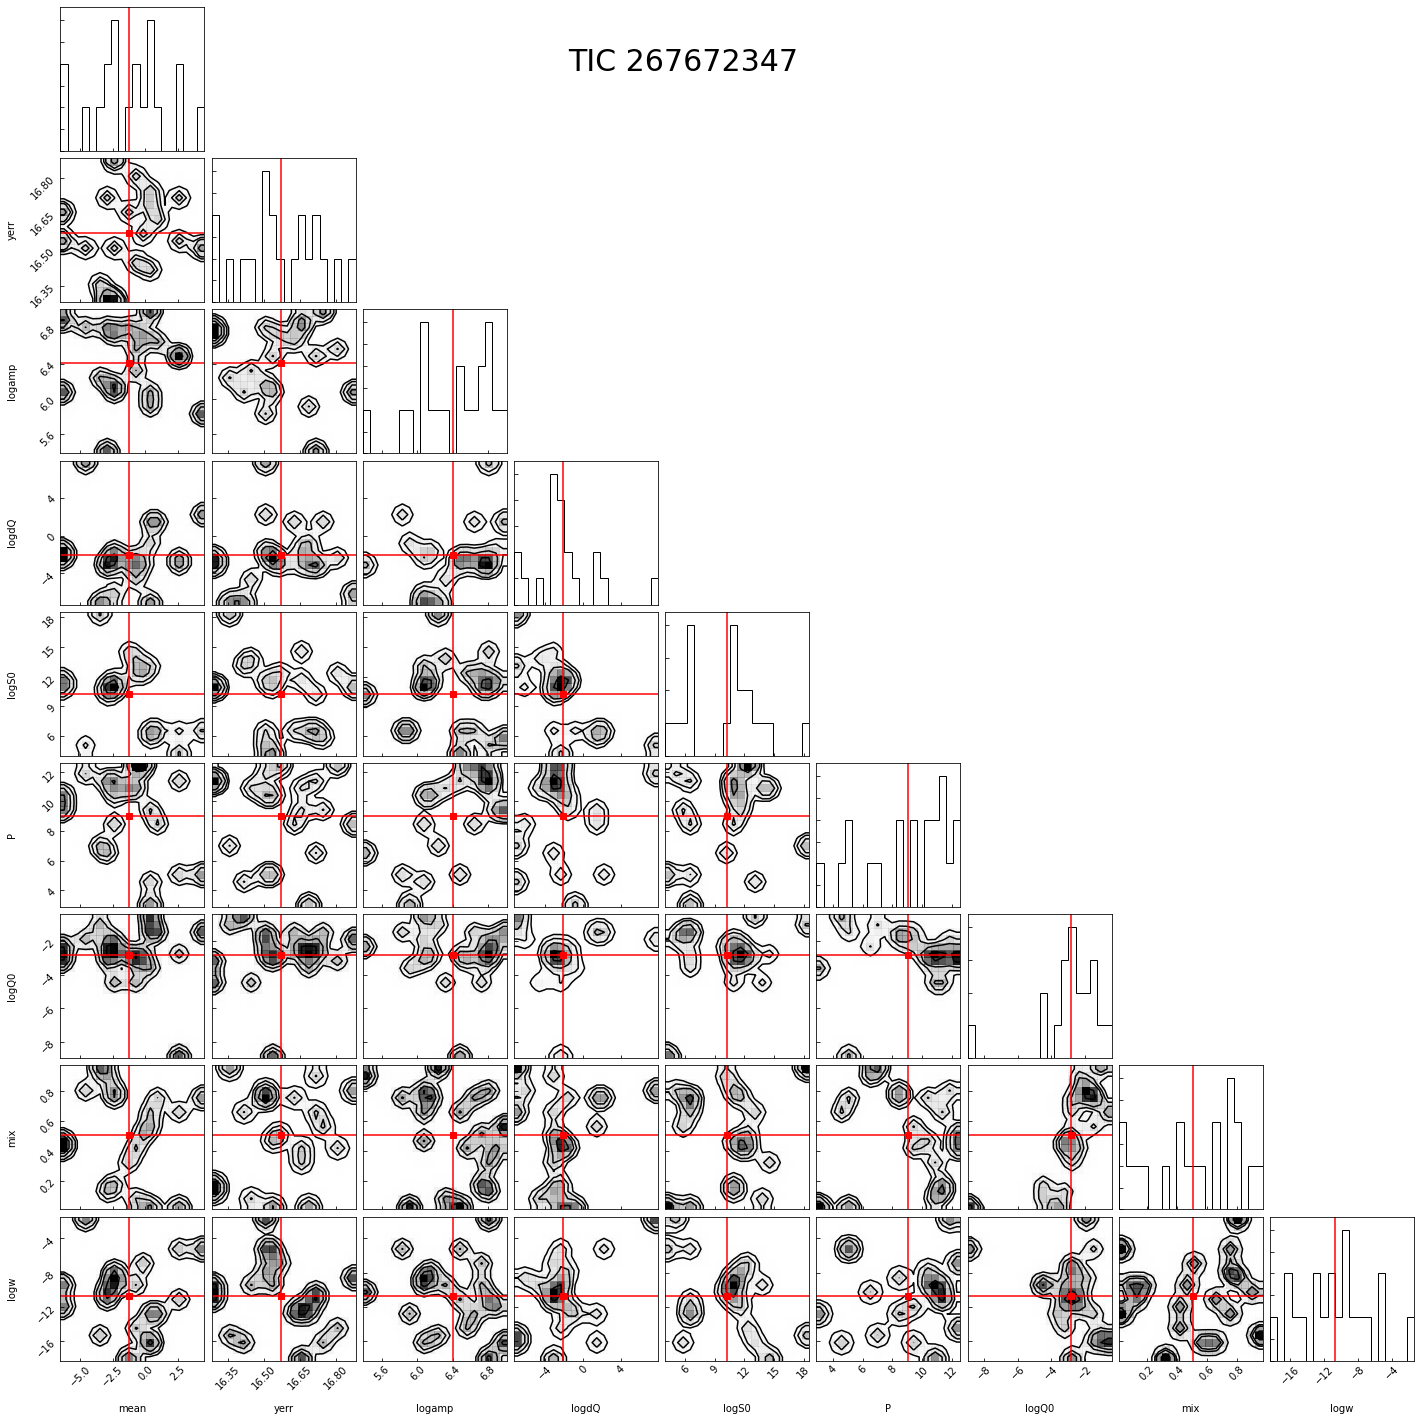

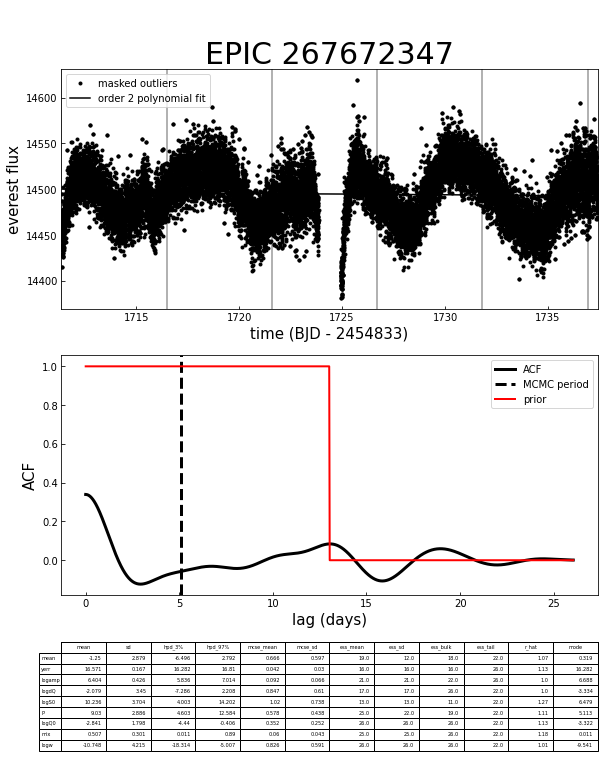

In [12]:
import imp
import plotting
imp.reload(utils)
imp.reload(plotting)

plotting.cornerplot(lc, trace, 'TIC', smooth=True, truth_color='r');
        
acf_kwargs = {'color': 'k', 'linewidth': 3}
pk_kwargs = {'color': 'r', 'linewidth': 1, 'linestyle': '--'}
all_acf_kwargs = {'peaks': True, 'acf_kwargs': acf_kwargs, 'pk_kwargs': pk_kwargs}

lc_kwargs = {'plot_outliers': True, 'plot_trend': True, 'uncertainties': False, 
             'highlight_color': 'k', 'vline_color': 'k', 
             'sigmaclip_kernel_size': 301, 'sigmaclip_sigma': 3}
prior_kwargs = {'color': 'r', 'linewidth': 2, 'normalize': True}
plotting.summaryplot(lc, trace, 'EPIC', plot_prior=True, plot_period=True,
                             acf_kwargs=all_acf_kwargs, 
                             lc_kwargs=lc_kwargs, 
                             prior_kwargs=prior_kwargs);
plotting.writesummary(lc, trace, 14, 'out.dat')

In [13]:
import pandas as pd
df = pd.read_csv('out.dat', sep='\t', skiprows=2)

In [14]:
df['P_mean']

0    7.437
1    9.030
Name: P_mean, dtype: float64

In [17]:
summary = pm.summary(trace, var_names=['yerr', 'mean', 'P', 'logQ0', 'logS0', 'logdQ', 'mix', 'logw', 'logamp'])
summary['mode'] = list(utils.modes(trace).values())

In [18]:
summary

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat,mode
yerr,16.571,0.167,16.282,16.810,0.042,0.030,16.0,16.0,16.0,26.0,1.13,0.319106
mean,-1.250,2.879,-6.496,2.792,0.666,0.597,19.0,12.0,18.0,22.0,1.07,16.282072
P,9.030,2.886,4.603,12.584,0.578,0.438,25.0,22.0,19.0,22.0,1.11,6.687723
logQ0,-2.841,1.798,-4.440,-0.406,0.352,0.252,26.0,26.0,26.0,22.0,1.13,-3.334214
logS0,10.236,3.704,4.003,14.202,1.020,0.738,13.0,13.0,11.0,22.0,1.27,6.479479
logdQ,-2.079,3.450,-7.286,2.208,0.847,0.610,17.0,17.0,26.0,22.0,1.00,5.113100
mix,0.507,0.301,0.011,0.890,0.060,0.043,25.0,25.0,26.0,22.0,1.18,-3.322461
logw,-10.748,4.215,-18.314,-5.007,0.826,0.591,26.0,26.0,26.0,22.0,1.01,0.011346
logamp,6.404,0.426,5.836,7.014,0.092,0.066,21.0,21.0,22.0,26.0,1.00,-9.541349


In [ ]:
import pymc3 as pm
pm.summary(trace)

In [ ]:
import itertools
columns = [c + "_" + n for c, n in 
               itertools.product(list(summary.index), 
                                 list(summary.columns))]

In [ ]:
summary.to_numpy().flatten()[48]

In [ ]:
columns